In [114]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from six.moves import cPickle as pickle
%matplotlib inline


In [2]:
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
mnist = input_data.read_data_sets('MNIST_data', one_hot = True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
type(mnist)

tensorflow.contrib.learn.python.learn.datasets.base.Datasets

In [5]:
mnist.train

In [107]:
mnist.train.labels.shape


(55000, 10)

In [25]:
a = mnist.train.images[7]
b = mnist.train.images[2]
a = a.reshape(28,28)
b = b.reshape(28,28)
c = np.zeros((28,28))
d = np.concatenate((a,b,c),axis = 1)

In [194]:
print mnist.train.images.shape,mnist.test.images.shape,mnist.validation.images.shape

(55000, 784) (10000, 784) (5000, 784)


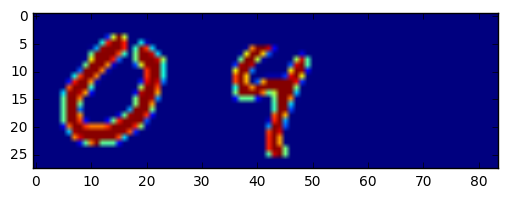

In [26]:
plt.imshow(d)
plt.show()

In [196]:
def Generate_dataset(original_dataset, dataset_size, max_length):
    labels_list = list()
    data_list = list()
    original_size = original_dataset.images.shape[0]
    for i in range(max_length):
        labels_list.append([])
    for i in range(dataset_size):
        num_length = random.randint(1, max_length)
        tmp = list()
        for j in range(max_length):
            if j < num_length:
                index = random.randint(0, original_size - 1)
#                 print index
                tmp.append(original_dataset.images[index].reshape(28,28))
                data_label = np.concatenate((original_dataset.labels[index], np.array([0])), axis = 0)
                labels_list[j].append(data_label.tolist())
                
            else:
                tmp.append(np.zeros((28,28)))
                data_label = np.concatenate((np.zeros(10), np.array([1])), axis=0)
                labels_list[j].append(data_label.tolist())
        data_list.append(np.concatenate(tmp, axis = 1).reshape((1, 28 * 28 * max_length)))
    labels_list = [np.array(i) for i in labels_list]
        
    return np.concatenate(data_list, axis = 0), labels_list
        
                
        
    
    

In [197]:
train_dataset, train_labels = Generate_dataset(mnist.train,55000,5)
valid_dataset, valid_labels = Generate_dataset(mnist.validation,5000,5)
test_dataset, test_labels = Generate_dataset(mnist.test,10000,5)

In [198]:
pickle_file = 'sequence.pickle'
try:
  with open(pickle_file, 'wb') as f:
      save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
        }
      pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)

except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise


In [204]:
pickle_file = 'sequence.pickle'
try:
    with open(pickle_file, 'rb') as f:
        dataset_dict = pickle.load(f)
        train_dataset = dataset_dict['train_dataset']
        test_dataset = dataset_dict['test_dataset']
        train_labels = dataset_dict['train_labels']
        valid_dataset = dataset_dict['valid_dataset']
        valid_labels = dataset_dict['valid_labels']
        test_labels = dataset_dict['test_labels']
    
except Exception as e:
    print ('Unable to load the data')
    raise

In [211]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale
def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size * 5, num_channels)).astype(np.float32)
  return dataset
train_dataset = reformat(train_dataset, train_labels)
valid_dataset = reformat(valid_dataset, valid_labels)
test_dataset = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape)
print('Validation set', valid_dataset.shape)
print('Test set', test_dataset.shape)

('Training set', (55000, 28, 140, 1))
('Validation set', (5000, 28, 140, 1))
('Test set', (10000, 28, 140, 1))


In [241]:
test = test_dataset[100]
print test_labels[1].shape

(10000, 11)


In [242]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
max_length = 5
num_labels = 11

graph = tf.Graph()

In [321]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
      return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
      return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
def accuracy(predictions, labels):
    accur = 0
    for index, item in enumerate(predictions):
        accur += np.sum(np.argmax(item, 1) == np.argmax(labels[index], 1))
#         print accur
#         print item.shape
    return (100.0 * accur / float(len(predictions) * predictions[0].shape[0]))
        
 

In [325]:
keep_prob = 0.5
graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size, image_size * 5, num_channels))
    tf_train_labels = list()
    for _ in range(max_length):
        tf_train_labels.append(tf.placeholder(tf.float32, shape = (batch_size, num_labels)))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    layer1_weights = weight_variable([patch_size, patch_size, num_channels, depth])
    layer1_bias = bias_variable([depth])
    layer2_weights = weight_variable([patch_size, patch_size, depth, depth])
    layer2_bias = bias_variable([depth])
    layer3_weights = weight_variable([image_size // 4 * image_size *5 // 4 * depth, num_hidden])
    layer3_bias = bias_variable([num_hidden])
    s1_w = weight_variable([num_hidden,num_labels])
    s1_b = bias_variable([num_labels])
    s2_w = weight_variable([num_hidden,num_labels])
    s2_b = bias_variable([num_labels])
    s3_w = weight_variable([num_hidden,num_labels])
    s3_b = bias_variable([num_labels])
    s4_w = weight_variable([num_hidden,num_labels])
    s4_b = bias_variable([num_labels])
    s5_w = weight_variable([num_hidden,num_labels])
    s5_b = bias_variable([num_labels])
    
    def model(data,train_only = True):
        conv = conv2d(data, layer1_weights)
        hidden_1 = tf.nn.relu(conv + layer1_bias)
        h_pool_1 = max_pool_2x2(hidden_1)
        if train_only:
            h_pool_1 = tf.nn.dropout(h_pool_1,keep_prob)
        conv = conv2d(h_pool_1, layer2_weights)
        hidden_2 = tf.nn.relu(conv + layer2_bias)
        h_pool_2 = max_pool_2x2(hidden_2)
        if train_only:
            h_pool_2 = tf.nn.dropout(h_pool_2,keep_prob)
        shape = h_pool_2.get_shape().as_list()
#         print type(shape)
#         print shape
        reshape = tf.reshape(h_pool_2, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_bias)
        if train_only:
            hidden = tf.nn.dropout(hidden,keep_prob)
        logits1 = tf.matmul(hidden, s1_w) + s1_b
        logits2 = tf.matmul(hidden, s2_w) + s2_b
        logits3 = tf.matmul(hidden, s3_w) + s3_b
        logits4 = tf.matmul(hidden, s4_w) + s4_b
        logits5 = tf.matmul(hidden, s5_w) + s5_b

        return [logits1,logits2,logits3,logits4,logits5]
    
    # Training computation.
    logits= model(tf_train_dataset)
    loss = 0
    for i in range(max_length):
        loss += tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels[i], logits=logits[i])) 

    # Optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # Predictions for the training, validation, and test data.
    logits_train = model(tf_train_dataset,False)
    logits_valid = model(tf_valid_dataset, False)
    logits_test = model(tf_test_dataset, False)
    train_prediction = tf.stack((tf.nn.softmax(logits_train[0]), tf.nn.softmax(logits_train[1]), tf.nn.softmax(logits_train[2]), \
                                 tf.nn.softmax(logits_train[3]), tf.nn.softmax(logits_train[4])))
    valid_prediction = tf.stack((tf.nn.softmax(logits_valid[0]), tf.nn.softmax(logits_valid[1]), tf.nn.softmax(logits_valid[2]),tf.nn.softmax(logits_valid[3]), tf.nn.softmax(logits_valid[4])))
    test_prediction = tf.stack((tf.nn.softmax(logits_test[0]), tf.nn.softmax(logits_test[1]), tf.nn.softmax(logits_test[2]),tf.nn.softmax(logits_test[3]), tf.nn.softmax(logits_test[4])))
    
    saver = tf.train.Saver()

In [326]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_dataset.shape[0] - batch_size)
    feed_dict = dict()
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    feed_dict[tf_train_dataset] = batch_data
    batch_labels = list()
    for i in range(max_length):
        batch_labels.append(train_labels[i][offset:(offset + batch_size), :])
        feed_dict[tf_train_labels[i]] = train_labels[i][offset:(offset + batch_size), :]
    
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
  save_path = saver.save(session, "CNN_multi.ckpt")
  print("Model saved in file: %s" % save_path)


Initialized
Minibatch loss at step 0: 23.000139
Minibatch accuracy: 11.2%
Validation accuracy: 32.2%
Minibatch loss at step 50: 7.808941
Minibatch accuracy: 42.5%
Validation accuracy: 44.6%
Minibatch loss at step 100: 8.102388
Minibatch accuracy: 43.8%
Validation accuracy: 45.5%
Minibatch loss at step 150: 7.234249
Minibatch accuracy: 45.0%
Validation accuracy: 47.4%
Minibatch loss at step 200: 9.511226
Minibatch accuracy: 30.0%
Validation accuracy: 47.2%
Minibatch loss at step 250: 7.562004
Minibatch accuracy: 46.2%
Validation accuracy: 49.0%
Minibatch loss at step 300: 7.953299
Minibatch accuracy: 46.2%
Validation accuracy: 49.4%
Minibatch loss at step 350: 5.745080
Minibatch accuracy: 63.8%
Validation accuracy: 51.0%
Minibatch loss at step 400: 6.558107
Minibatch accuracy: 60.0%
Validation accuracy: 53.9%
Minibatch loss at step 450: 5.990222
Minibatch accuracy: 63.8%
Validation accuracy: 55.8%
Minibatch loss at step 500: 5.345458
Minibatch accuracy: 72.5%
Validation accuracy: 55.9%


In [284]:
print train_dataset.shape

(55000, 28, 140, 1)


In [317]:
def accuracy(predictions, labels):
    accur = 0
    for index, item in enumerate(predictions):
        accur += np.sum(np.argmax(item, 1) == np.argmax(labels[index], 1))
        print accur
        print item.shape
    return (accur / float(len(predictions) * predictions[0].shape[0]))

In [318]:
accuracy(train_labels,train_labels)

55000
(55000, 11)
110000
(55000, 11)
165000
(55000, 11)
220000
(55000, 11)
275000
(55000, 11)


1.0

In [111]:
a = data[9].reshape((28, 28 * 5))

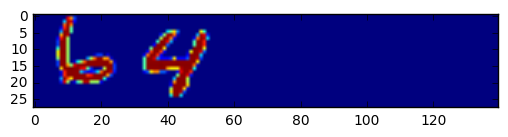

In [137]:
plt.imshow(a)
plt.show()

In [303]:
for i in range(5):
    print label[i][9]

[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


In [55]:
labels_list = list()
for i in range(5):
    labels_list.append([])
print labels_list
labels_list[1].append(np.zeros(2))
print labels_list

[[], [], [], [], []]
[[], [array([ 0.,  0.])], [], [], []]


In [35]:
np.zeros(10)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [118]:
import PIL

In [119]:
from PIL import Image

In [178]:
im = Image.fromarray(a)

In [175]:
im.rotate(45).show()

In [183]:
test=im.resize((28,28), PIL.Image.ANTIALIAS)

In [184]:
b = np.array(test.getdata()).reshape(28, 28 )

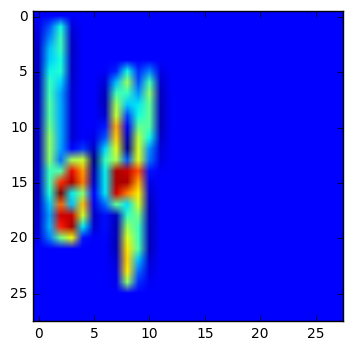

In [185]:
plt.imshow(b)
plt.show()

In [231]:
test= Image.open('test.jpg')
test_2 = test.resize((28,28), PIL.Image.ANTIALIAS)

In [232]:
np.array(test_2.getdata()).reshape(28,28)

ValueError: cannot reshape array of size 2352 into shape (28,28)

In [235]:
b = np.array(test_2.getdata()).reshape(28,28,3)
print b.shape

(28, 28, 3)


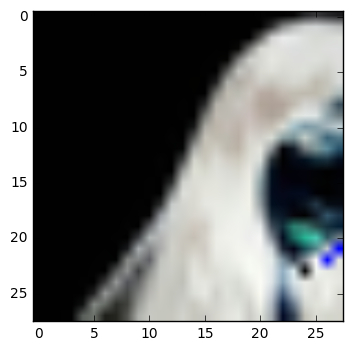

In [234]:
plt.imshow(b)
plt.show()